In [1]:
import h5py
import numpy as np
import netCDF4
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib.colors import from_levels_and_colors
from matplotlib import colors
plt.rcParams['figure.figsize'] = 15,8

# import module which makes daily and annual average concentrations from hourly concentrations
import lib_proj_from_cctm_to_rio.cctm_average  as cctm_average
# import module which makes linear interpolation
import lib_proj_from_cctm_to_rio.lin_interpol as linpy

#############################################################################################################################
#choose element and coeficients
#
#
#############################################################################################################################
# choose element
element='pm25' 
# coeficient from the ppbV to \mu g/ m^3 for gasses. In case of particle set coef =1
coef=1

#read cmaq grid
grid_CMAQ=netCDF4.Dataset('/data/mala/GRIDCRO2D_01012015.nc')

# lon, lat from CMAQ grid with appropriate shape 
lon=np.array(grid_CMAQ.variables['LON'][0,0,2:101,2:180])
lat=np.array(grid_CMAQ.variables['LAT'][0,0,2:101,2:180])

############################################################################################################################
#read inputs files, set the paths 
#
#
#############################################################################################################################

#rio hdf5 file base year
file = h5py.File('/media/sf_Share/LifeIP_results_RIO/LifeIP_results_RIO/PM25/2015_RIO_output_daily_average/rio_pm25_da_clc12_47x47_20150101-20151231.h5','r')
#cmaq base year
model_CMAQ=netCDF4.Dataset('/media/sf_Share/TERKA/LIFEIP_Small_PM_2015')
#cmaq W1 year
model_CMAQ_W1=netCDF4.Dataset('/data/bussines_as_ussual/post_W1_PM')
#cmaq bussines as usual
model_CMAQ_BAU=netCDF4.Dataset('/data/bussines_as_ussual/post_nevnor_PM')
#camx bussines as usual
#model_CAMX_BAU=netCDF4.Dataset('/media/sf_Share/TERKA/Life-MP_ref2015_camxout_avrg.grd02_IL_PMspec.nc')


############################################################################################################################
#prepare CMAQ, and RIO daily and annual average  concentration, the shapes are adjusted in order to fit all thre models
#
#
############################################################################################################################

#CMAQ base year#############################################################################################################
cmaq_daily=cctm_average.daily(np.array(coef*model_CMAQ.variables[element.upper()][:,0,2:101,2:180]))
cmaq_ann=cctm_average.annual(cmaq_daily)

#CMAQ bussines as ussual####################################################################################################
cmaq_daily_BAU=cctm_average.daily(np.array(coef*model_CMAQ_BAU.variables[element.upper()][:,0,2:101,2:180]))
cmaq_ann_BAU=cctm_average.annual(cmaq_daily_BAU)

#CMAQ W1##################################################################################################################
cmaq_daily_W1=cctm_average.daily(np.array(coef*model_CMAQ_W1.variables[element.upper()][:,0,2:101,2:180]))
cmaq_ann_W1=cctm_average.annual(cmaq_daily_W1)

#rio base year##############################################################################################################
rio_daily=np.array(file['grid/value'][:])
rio_daily=np.reshape(rio_daily,(101,179,365))[1:100,1:]

rio_ann=np.empty((99,178))
rio_ann=np.average(rio_daily[:,:,:], axis=2)

#reshape rio_daily in order to have time variables as first index
rio_reshape=np.empty((365,99,178))

for i in range(0,cmaq_ann.shape[0]):
    for j in range(0,cmaq_ann.shape[1]):
        rio_reshape[:,i,j]=rio_daily[i,j,:] 

rio_daily=rio_reshape

/home/p6001/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
############################################################################################################################
#CCTM base year - scenario interpolation just linear methods
#
#
############################################################################################################################
rio_daily_BAU_linear=np.empty((365,99,178))
rio_daily_W1_linear=np.empty((365,99,178))



for i in range(0,cmaq_ann.shape[0]):
    for j in range(0,cmaq_ann.shape[1]):
        #linear interpolation BAU
        m,b,r =linpy.lin_interpol(cmaq_daily[:,i,j], cmaq_daily_BAU[:,i,j])    
        #linear interpolation W1
        m_w,b_w,r_w =linpy.lin_interpol(cmaq_daily[:,i,j], cmaq_daily_W1[:,i,j])    
        
        for k in range(0,365):
            #linear interpolation BAU
            rio_daily_BAU_linear[k,i,j]=rio_daily[k,i,j]*m+b
            #linear interpolation W1
            rio_daily_W1_linear[k,i,j]=rio_daily[k,i,j]*m_w+b_w

rio_ann_BAU_linear=np.average(rio_daily_BAU_linear[:,:,:], axis=0)
rio_ann_W1_linear=np.average(rio_daily_W1_linear[:,:,:], axis=0)      

PLOT ANNUAL CONCENTRATION GRAPHS AND DIFFERENCES

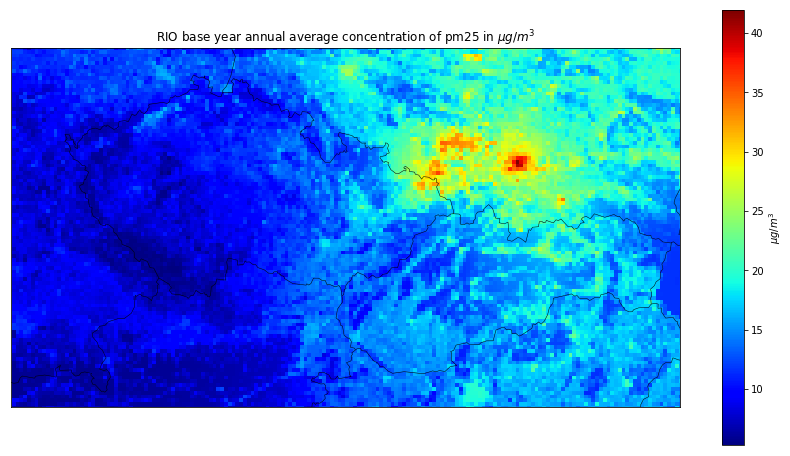

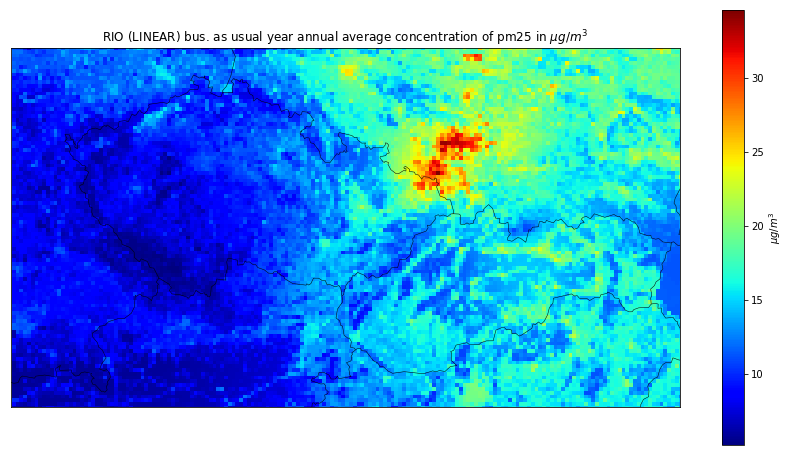

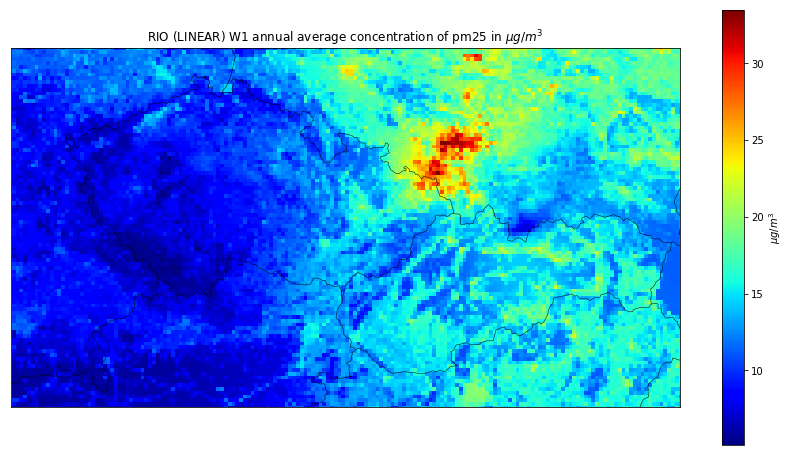

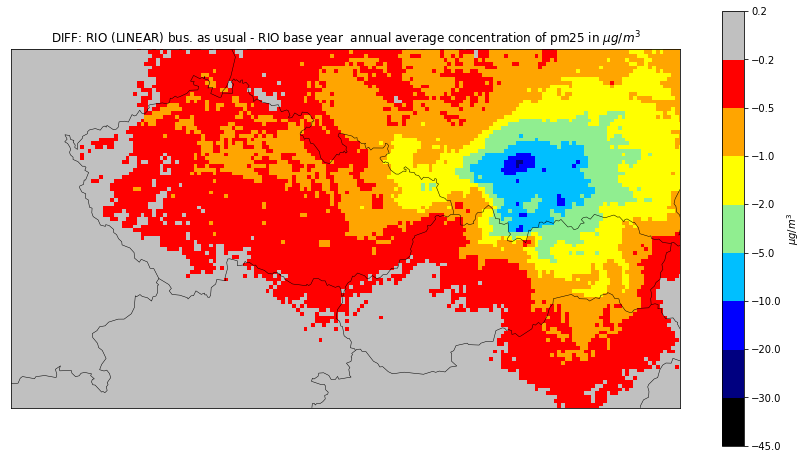

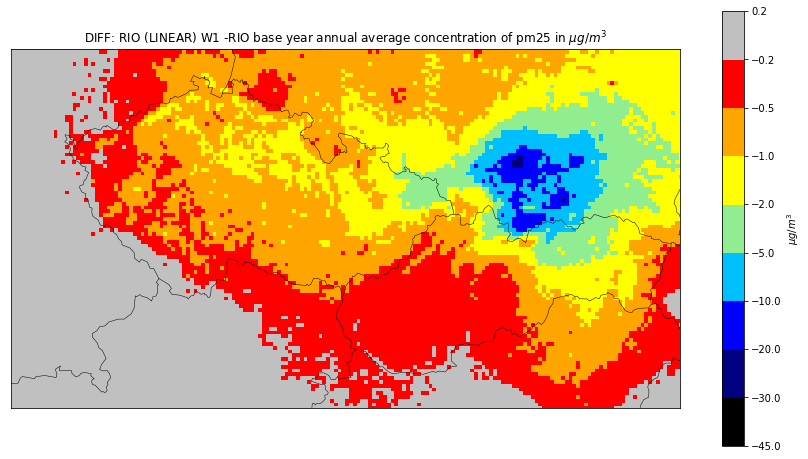

In [3]:
plt.rcParams['figure.figsize'] = 15,8
mapb=Basemap(projection='lcc',lat_1=46.24470138549805,lat_2=46.24470138549805,lat_0=49.375,lon_0=17.0,width=832900,height=446351,resolution='i')
mapb.drawcountries()

# choose one of the two style of the plot
mapb.pcolormesh(lon,lat,rio_ann,cmap=plt.cm.jet,latlon=True) 
#mapb.contourf(lon,lat,dic_ann[i],cmap=plt.cm.jet,latlon=True,norm=colors.LogNorm()) 

plt.colorbar(label='$\mu g /m^3$')
plt.title('RIO base year annual average concentration of {0} in $\mu g /m^3$'.format(element))
plt.show()
plt.close() 
#################################################################################################################
mapb.drawcountries()

# choose one of the two style of the plot
mapb.pcolormesh(lon,lat,rio_ann_BAU_linear,cmap=plt.cm.jet,latlon=True) 
#mapb.contourf(lon,lat,dic_ann[i],cmap=plt.cm.jet,latlon=True,norm=colors.LogNorm()) 

plt.colorbar(label='$\mu g /m^3$')
plt.title('RIO (LINEAR) bus. as usual year annual average concentration of {0} in $\mu g /m^3$'.format(element))
plt.show()
plt.close() 
##################################################################################################################
mapb.drawcountries()

# choose one of the two style of the plot
mapb.pcolormesh(lon,lat,rio_ann_W1_linear,cmap=plt.cm.jet,latlon=True) 
#mapb.contourf(lon,lat,dic_ann[i],cmap=plt.cm.jet,latlon=True,norm=colors.LogNorm()) 

plt.colorbar(label='$\mu g /m^3$')
plt.title('RIO (LINEAR) W1 annual average concentration of {0} in $\mu g /m^3$'.format(element))
plt.show()
plt.close() 





cmap, norm = from_levels_and_colors([-45,-30,-20,-10,-5,-2,-1,-0.5,-0.2,0.2], ['black','navy','blue', 'deepskyblue','lightgreen','yellow','orange','red','silver'])
################################################################################################################
mapb.drawcountries()

# choose one of the two style of the plot
mapb.pcolormesh(lon,lat,rio_ann_BAU_linear-rio_ann,cmap=cmap,norm=norm,latlon=True) 
#mapb.contourf(lon,lat,dic_ann[i],cmap=plt.cm.jet,latlon=True,norm=colors.LogNorm()) 

plt.colorbar(label='$\mu g /m^3$')
plt.title('DIFF: RIO (LINEAR) bus. as usual - RIO base year  annual average concentration of {0} in $\mu g /m^3$'.format(element))
plt.show()
plt.close() 
######################################################################################################################
mapb.drawcountries()

# choose one of the two style of the plot
mapb.pcolormesh(lon,lat,rio_ann_W1_linear-rio_ann,cmap=cmap,norm=norm,latlon=True) 
#mapb.contourf(lon,lat,dic_ann[i],cmap=plt.cm.jet,latlon=True,norm=colors.LogNorm()) 

plt.colorbar(label='$\mu g /m^3$')
plt.title('DIFF: RIO (LINEAR) W1 -RIO base year annual average concentration of {0} in $\mu g /m^3$'.format(element))
plt.show()
plt.close() 

